In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as st

### Read In CSVs

In [2]:
raw_combine_data=pd.read_csv('Resources/raw_combine_data.csv')
raw_nba_data=pd.read_csv('Resources/raw_nba_data.csv')
season_data_df=pd.read_csv('Resources/season_data_height.csv')

### Finding Duplicates

In [3]:
nba_duplicates=raw_nba_data[raw_nba_data.duplicated(['PLAYER'])]
combine_duplicates=raw_combine_data[raw_combine_data.duplicated(['PLAYER'])]

### Drop Duplicates from Dataframes

In [4]:
dropped_combine_data=raw_combine_data.drop_duplicates(subset='PLAYER',keep='first')
dropped_nba_data=raw_nba_data.drop_duplicates(subset='PLAYER',keep='first')

### Merge DataFrames

In [5]:
merged_data_df=dropped_combine_data.merge(dropped_nba_data, on='PLAYER')

### Remove Players Who Didn't Take Enough Shots to Include in Analysis

In [6]:
merged_data_df=merged_data_df[merged_data_df['3PA']>10]
merged_data_df=merged_data_df[merged_data_df['2PA']>10]
merged_data_df=merged_data_df[merged_data_df['FTA']>10]

### Drop Rows w/ Missing Wingspan & Height Data

In [7]:
merged_data_df=merged_data_df.dropna(subset=['WINGSPAN'])
merged_data_df=merged_data_df.dropna(subset=['HEIGHT\xa0W/O\xa0SHOES'])

merged_data_df.reset_index(inplace=True)
merged_data_df.drop(axis=1, labels='index', inplace=True)

### Export as CSV

In [8]:
merged_data_df.to_csv("Resources/merged_data.csv",index=False)

### Narrowing Down 2PA, 3PA, FTA Criteria

In [9]:
# Calculate the IQR and quantitatively determine if there are any potential outliers and append them to a dataframe
df=pd.DataFrame({'2PA':["","","","","","",""],
                 'FTA':["","","","","","",""],
                 '3PA':["","","","","","",""]
                })
df=df.set_index(keys=[["Lower Quartile","Median","Upper Quartile","IQR","Lower Bound","Upper Bound","Std"]]) #set index

for data in df:
    quartiles = merged_data_df[data].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    median= quartiles[0.5]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    df[data][0]=lowerq
    df[data][1]=median
    df[data][2]=upperq
    df[data][3]=iqr
    df[data][4]=lower_bound
    df[data][5]=upper_bound
    df[data][6]=merged_data_df[data].std()
df

,2PA,FTA,3PA
Lower Quartile,110.5,42.5,78.5
Median,215,83,154
Upper Quartile,371.5,142.5,248
IQR,261,100,169.5
Lower Bound,-281,-107.5,-175.75
Upper Bound,763,292.5,502.25
Std,214.517,110.703,130.481


### Wingspan Conversion to Inches

In [10]:
wingspan = []
wingspan_convert=[]

wingspan = merged_data_df['WINGSPAN']
wingspan_list = wingspan.tolist()
for wingspan in wingspan_list:
    wingspan_cleaned = wingspan.strip("'").split("'")
    wingspan_convert.append((int(wingspan_cleaned[0])*12)+(float(wingspan_cleaned[1])))

merged_data_df['WINGSPAN']=wingspan_convert

### Height w/o Shoes Conversion to Inches

In [11]:
height_wo_shoes = []
height_wo_shoes_convert=[]

height_wo_shoes = merged_data_df['HEIGHT\xa0W/O\xa0SHOES']
height_wo_shoes_list = height_wo_shoes.tolist()
height_wo_shoes_list
for height in height_wo_shoes_list:
    height_cleaned = str(height).strip(" ' ").split("'")
    height_wo_shoes_convert.append((int(height_cleaned[0])*12)+(float(height_cleaned[1])))
    
merged_data_df['HEIGHT\xa0W/O\xa0SHOES']=height_wo_shoes_convert

# Scatter Plots

## Wingspan vs. Free Throws

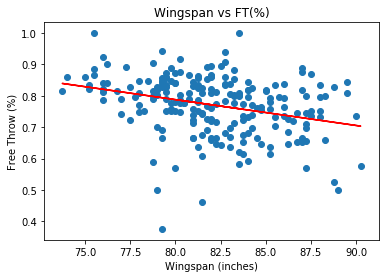

The correlation between both factors is -0.3


In [12]:

(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['FT%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values, color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['FT%'])
plt.ylabel('Free Throw (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs FT(%)")
plt.show()
correlation = st.pearsonr(wingspan_convert,merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Wingspan vs. 2P%

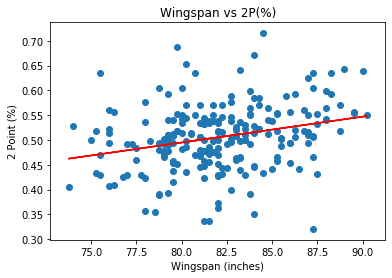

The correlation between both factors is 0.27


In [13]:

(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['2P%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values, color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['2P%'])
plt.ylabel('2 Point (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs 2P(%)")
plt.show()
correlation = st.pearsonr(wingspan_convert,merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Wingspan vs. 3P%

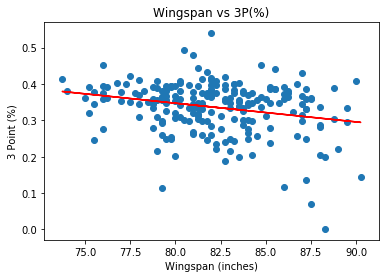

The correlation between both factors is -0.25


In [14]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(wingspan_convert, merged_data_df['3P%'] )
regress_values = np.array(wingspan_convert) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(wingspan_convert,regress_values,color='red')
plt.scatter(x=wingspan_convert, y=merged_data_df['3P%'])
plt.ylabel('3 Point (%)')
plt.xlabel('Wingspan (inches)')
plt.title("Wingspan vs 3P(%)")
plt.show()
correlation = st.pearsonr(wingspan_convert,merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Height vs. FT%

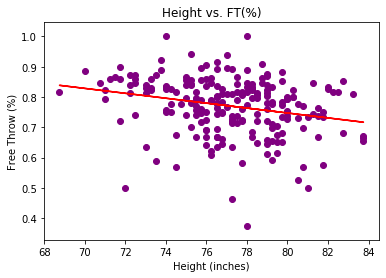

The correlation between both factors is -0.25


In [15]:
(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['FT%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['FT%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['FT%'], color = "purple")
plt.xlabel('Height (inches)')
plt.ylabel('Free Throw (%)')
plt.title('Height vs. FT(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()
correlation = st.pearsonr(height_wo_shoes_convert,merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Height vs. 2P%

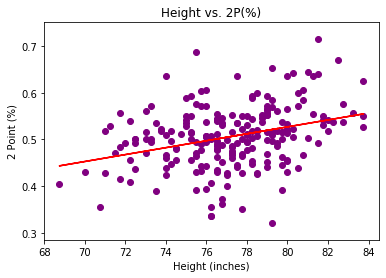

The correlation between both factors is 0.32


In [16]:
(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['2P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['2P%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['2P%'], color = "purple")
plt.xlabel('Height (inches)')
plt.ylabel('2 Point (%)')
plt.title('Height vs. 2P(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()
correlation = st.pearsonr(height_wo_shoes_convert,merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Height vs. 3P%

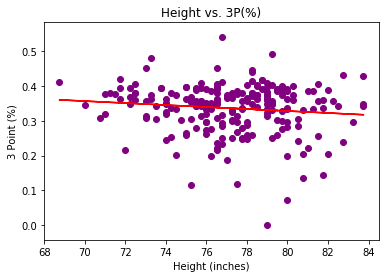

The correlation between both factors is -0.12


In [17]:
(correlation_coefficient) = st.pearsonr(height_wo_shoes_convert, merged_data_df['3P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(height_wo_shoes_convert, merged_data_df['3P%'])

#Slope formula 'y=mx+b'
y = slope * np.array(height_wo_shoes_convert) + intercept

plt.scatter(x = height_wo_shoes_convert, y = merged_data_df['3P%'], color = "purple")
plt.xlabel('Height (inches)')
plt.ylabel('3 Point (%)')
plt.title('Height vs. 3P(%)')

plt.plot(height_wo_shoes_convert, y, color = 'red')
plt.show()
correlation = st.pearsonr(height_wo_shoes_convert,merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Establish RATIO = (Wingspan / Height)

In [18]:
ratio_wing_over_height = []

for i in range(len(wingspan_convert)):
    ratio_wing_over_height.append(wingspan_convert[i] / height_wo_shoes_convert[i])

## Ratio vs. FT%

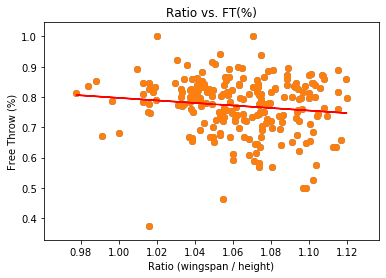

The correlation between both factors is -0.13


In [19]:
plt.scatter(ratio_wing_over_height,merged_data_df["FT%"])

correlation_coefficient = st.pearsonr(ratio_wing_over_height, merged_data_df['FT%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(ratio_wing_over_height, merged_data_df['FT%'])

y = slope * np.array(ratio_wing_over_height) + intercept

plt.scatter(x = ratio_wing_over_height, y = merged_data_df['FT%'])
plt.xlabel('Ratio (wingspan / height)')
plt.ylabel('Free Throw (%)')
plt.title('Ratio vs. FT(%)')

plt.plot(ratio_wing_over_height, y, color = 'red')
plt.show()
correlation = st.pearsonr(ratio_wing_over_height,merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Ratio vs. 2P%

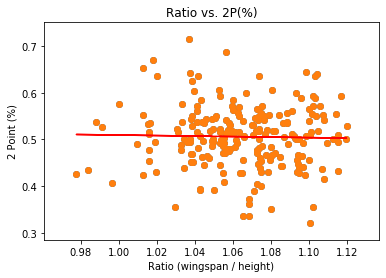

The correlation between both factors is -0.02


In [20]:
plt.scatter(ratio_wing_over_height,merged_data_df["2P%"])

correlation_coefficient = st.pearsonr(ratio_wing_over_height, merged_data_df['2P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(ratio_wing_over_height, merged_data_df['2P%'])

y = slope * np.array(ratio_wing_over_height) + intercept

plt.scatter(x = ratio_wing_over_height, y = merged_data_df['2P%'])
plt.xlabel('Ratio (wingspan / height)')
plt.ylabel('2 Point (%)')
plt.title('Ratio vs. 2P(%)')

plt.plot(ratio_wing_over_height, y, color = 'red')
plt.show()
correlation = st.pearsonr(ratio_wing_over_height,merged_data_df['2P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## Ratio vs. 3P%

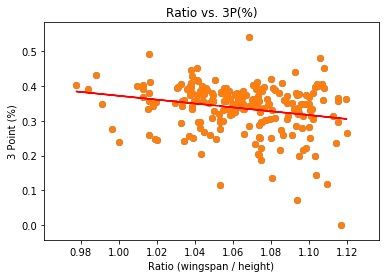

The correlation between both factors is -0.22


In [21]:
plt.scatter(ratio_wing_over_height,merged_data_df["3P%"])

(correlation_coefficient) = st.pearsonr(ratio_wing_over_height, merged_data_df['3P%'])[0]
(slope, intercept, r_value, p_value, standard_error) = st.linregress(ratio_wing_over_height, merged_data_df['3P%'])

y = slope * np.array(ratio_wing_over_height) + intercept

plt.scatter(x = ratio_wing_over_height, y = merged_data_df['3P%'])
plt.xlabel('Ratio (wingspan / height)')
plt.ylabel('3 Point (%)')
plt.title('Ratio vs. 3P(%)')

plt.plot(ratio_wing_over_height, y, color = 'red')
plt.show()
correlation = st.pearsonr(ratio_wing_over_height,merged_data_df['3P%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

## 

In [22]:
#Find the optimal height that people play for each of their positions
merged_data_df.groupby('Pos')['HEIGHT\xa0W/O\xa0SHOES'].min()

Pos
C        79.00
C-PF     79.00
PF       76.50
PF-SF    77.75
PG       68.75
SF       75.75
SF-PF    79.00
SG       70.75
Name: HEIGHT W/O SHOES, dtype: float64

In [23]:
merged_data_df.groupby('POS')[['HEIGHT\xa0W/O\xa0SHOES', 'FT%', '2P%', '3P%', 'FTA', '2PA', '3PA']].mean()

,HEIGHT W/O SHOES,FT%,2P%,3P%,FTA,2PA,3PA
POS,,,,,,,
C,82.208333,0.696000,0.568500,0.261333,101.833333,275.166667,120.666667
C-PF,82.600000,0.747400,0.571000,0.325000,103.000000,211.800000,120.600000
PF,79.970588,0.730706,0.534353,0.309971,106.794118,258.852941,129.941176
PF-C,81.500000,0.811200,0.541000,0.390800,183.400000,401.200000,140.000000
PF-SF,78.500000,0.779750,0.496750,0.327250,95.500000,186.250000,156.000000
PG,73.477273,0.799409,0.483205,0.345091,137.704545,316.704545,199.613636
PG-SG,75.000000,0.782000,0.516833,0.324500,105.500000,355.833333,233.333333
SF,78.322368,0.749184,0.508158,0.339368,101.105263,255.578947,164.000000
SF-PF,78.687500,0.781000,0.548000,0.347000,115.000000,347.000000,255.750000


In [24]:
#Traditional Big men players are not as common and are mainly used to stretch the floor 
#rather than score points by posting up near the basket

tall_avg_ser=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] >= 77.75,:][['FTA','FT%','2PA','2P%','3PA', '3P%']].mean()
tall_med_ser=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] >= 77.75,:][['FTA','FT%','2PA','2P%','3PA', '3P%']].median()
tall_count=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] >= 77.75,:].count()['PLAYER']

short_avg_ser=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:][['FTA','FT%','2PA','2P%','3PA', '3P%']].mean()
short_med_ser=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:][['FTA','FT%','2PA','2P%','3PA', '3P%']].median()
short_count=merged_data_df.loc[merged_data_df['HEIGHT\xa0W/O\xa0SHOES'] < 77.75,:].count()['PLAYER']


In [25]:
central_tendency_df=pd.DataFrame({'Mean (Tall)':tall_avg_ser,
              'Median (Tall)':tall_med_ser,
              'Mean (Short)':short_avg_ser,
              'Median (Short)':short_med_ser   
})
central_tendency_df

,Mean (Tall),Median (Tall),Mean (Short),Median (Short)
FTA,112.393939,83.000,115.758333,81.0000
FT%,0.752929,0.774,0.784500,0.7995
2PA,272.444444,192.000,275.341667,231.5000
2P%,0.525717,0.522,0.489742,0.4935
3PA,162.313131,142.000,196.825000,158.0000
3P%,0.334354,0.356,0.337950,0.3510


## Tall vs Short Attempts Histogram

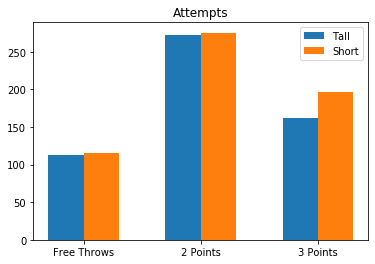

In [26]:
N = 3
tall_players_stats = (112.393939, 272.444444, 162.313131)
short_players_stats = (115.758333, 275.341667, 196.825000)

ind = np.arange(N) 
width = 0.30

plt.bar(ind, tall_players_stats, width, label='Tall')
plt.bar(ind + width, short_players_stats, width, label='Short')

plt.title('Attempts')

plt.xticks(ind + width / 2, ('Free Throws', '2 Points', '3 Points'))
plt.legend(loc='best')
plt.show()

## Tall vs Short Percentage Histogram

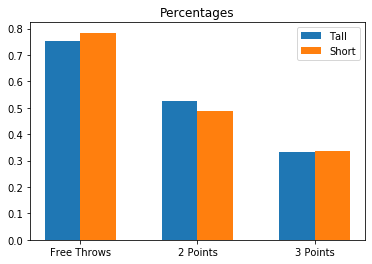

In [27]:
N = 3
tall_players_stats = (0.752929, 0.525717, 0.334354)
short_players_stats = (0.784500, 0.489742, 0.337950)

ind = np.arange(N) 
width = 0.30

plt.bar(ind, tall_players_stats, width, label='Tall')
plt.bar(ind + width, short_players_stats, width, label='Short')

plt.title('Percentages')

plt.xticks(ind + width / 2, ('Free Throws', '2 Points', '3 Points'))
plt.legend(loc='best')
plt.show()

## Correlations

In [28]:
# Height------------------------------------------------------------------------------------------------------
 
print("---------------Height Correlation-------------")
correlation = st.pearsonr(height_wo_shoes_convert,merged_data_df['2P%'])
print(f"The correlation between Height and 2P% is {round(correlation[0],2)}")

correlation = st.pearsonr(height_wo_shoes_convert,merged_data_df['3P%'])
print(f"The correlation between Height and 3P% is {round(correlation[0],2)}")

correlation = st.pearsonr(height_wo_shoes_convert,merged_data_df['FT%'])
print(f"The correlation between Height and FT% is {round(correlation[0],2)}")
print('\n')


# Wingspan------------------------------------------------------------------------------------------------------
 
print("---------------Wingspan Correlation-------------")
correlation = st.pearsonr(wingspan_convert,merged_data_df['2P%'])
print(f"The correlation between Wingspan and 2P% is {round(correlation[0],2)}")

correlation = st.pearsonr(wingspan_convert,merged_data_df['3P%'])
print(f"The correlation between Wingspan and 3P% is {round(correlation[0],2)}")

correlation = st.pearsonr(wingspan_convert,merged_data_df['FT%'])
print(f"The correlation between Wingspan and FT% is {round(correlation[0],2)}")
print('\n')


# Ratio------------------------------------------------------------------------------------------------------

print("---------------Ratio Correlation----------------")
correlation = st.pearsonr(ratio_wing_over_height,merged_data_df['2P%'])
print(f"The correlation between Ratio and 2P% is {round(correlation[0],2)}")

correlation = st.pearsonr(ratio_wing_over_height,merged_data_df['3P%'])
print(f"The correlation between Ratio and 3P% is {round(correlation[0],2)}")

correlation = st.pearsonr(ratio_wing_over_height,merged_data_df['FT%'])
print(f"The correlation between Ratio and FT% is {round(correlation[0],2)}")
print('\n')


# 2PA------------------------------------------------------------------------------------------------------
 
print("------------------2PA Correlation----------------")
correlation = st.pearsonr(merged_data_df['2PA'],merged_data_df['2P%'])
print(f"The correlation between 2PA and 2P% is {round(correlation[0],2)}")

correlation = st.pearsonr(merged_data_df['2PA'],merged_data_df['3P%'])
print(f"The correlation between 2PA and 3P% is {round(correlation[0],2)}")

correlation = st.pearsonr(merged_data_df['2PA'],merged_data_df['FT%'])
print(f"The correlation between 2PA and FT% is {round(correlation[0],2)}")
print('\n')

# 3PA------------------------------------------------------------------------------------------------------

print("------------------3PA Correlation----------------")
correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['2P%'])
print(f"The correlation between 3PA and 2P%  is {round(correlation[0],2)}")

correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['3P%'])
print(f"The correlation between 3PA and 3P%  is {round(correlation[0],2)}")

correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['FT%'])
print(f"The correlation between 3PA and FT%  is {round(correlation[0],2)}")
print('\n')


# FTA------------------------------------------------------------------------------------------------------

print("------------------FTA Correlation----------------")
correlation = st.pearsonr(merged_data_df['FTA'],merged_data_df['2P%'])
print(f"The correlation between FTA and 2P%  is {round(correlation[0],2)}")

correlation = st.pearsonr(merged_data_df['FTA'],merged_data_df['3P%'])
print(f"The correlation between FTA and 3P%  is {round(correlation[0],2)}")

correlation = st.pearsonr(merged_data_df['FTA'],merged_data_df['FT%'])
print(f"The correlation between FTA and FT%  is {round(correlation[0],2)}")

---------------Height Correlation-------------
The correlation between Height and 2P% is 0.32
The correlation between Height and 3P% is -0.12
The correlation between Height and FT% is -0.25


---------------Wingspan Correlation-------------
The correlation between Wingspan and 2P% is 0.27
The correlation between Wingspan and 3P% is -0.25
The correlation between Wingspan and FT% is -0.3


---------------Ratio Correlation----------------
The correlation between Ratio and 2P% is -0.02
The correlation between Ratio and 3P% is -0.22
The correlation between Ratio and FT% is -0.13


------------------2PA Correlation----------------
The correlation between 2PA and 2P% is 0.11
The correlation between 2PA and 3P% is 0.05
The correlation between 2PA and FT% is 0.2


------------------3PA Correlation----------------
The correlation between 3PA and 2P%  is -0.03
The correlation between 3PA and 3P%  is 0.42
The correlation between 3PA and FT%  is 0.37


------------------FTA Correlation-------------

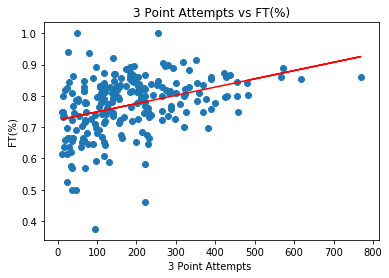

The line of best fit is : y = 0.0x + 0.72
The correlation between both factors is 0.37


In [29]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(merged_data_df['3PA'], merged_data_df['FT%'] )
regress_values = np.array(merged_data_df['3PA']) * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(merged_data_df['3PA'],regress_values,color='red')
plt.scatter(x=merged_data_df['3PA'], y=merged_data_df['FT%'])
plt.ylabel('FT(%)')
plt.xlabel('3 Point Attempts ')
plt.title("3 Point Attempts vs FT(%)")
plt.show()
print(f"The line of best fit is : {line_eq}")
correlation = st.pearsonr(merged_data_df['3PA'],merged_data_df['FT%'])
print(f"The correlation between both factors is {round(correlation[0],2)}")

In [30]:
#There are 5 positions in basketball
#Assign players position based on the first position provided
#THIS WOULD GO NEAR TOP WHEN CLEANING AND FILTERING DATA
merged_data_df_copy=merged_data_df

merged_data_df_copy["POS"].replace({"PF-C":"PF","C-PF": "C", "PF-SF": "PF", "SF-PF":"SF","SG-PG":'SG',"PG-SG":"PG","SG-SF":"SG","SF-SG":"SF"}, inplace=True)

merged_data_df_copy["POS"].unique() #Check that there are only 5 position

array(['PF', 'PG', 'SF', 'SG', 'C'], dtype=object)

In [31]:
#Traditionally taller players are assigned the positions of CENTER, POWER FORWARD, & SMALL FORWARD
tall_short_list=[]
for index, row in merged_data_df_copy.iterrows():
    if row['POS']=='PF':
        tall_short_list.append('Tall')
    elif row['POS']=='SF':
        tall_short_list.append('Tall')
    elif row['POS']=='C':
        tall_short_list.append('Tall')
    else:
        tall_short_list.append('Short')
        
merged_data_df_copy['Tall_Short']=tall_short_list

In [32]:
merged_data_df_copy

,PLAYER,POS,BODY FAT %,HAND LENGTH (INCHES),HAND WIDTH (INCHES),HEIGHT W/O SHOES,HEIGHT W/ SHOES,STANDING REACH,WEIGHT (LBS),WINGSPAN,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Tall_Short
0,Aaron Gordon,PF,5.05%,8.75,10.5,79.50,6' 8.75'',8' 9'',220.1,83.75,...,103,338,441,215,50,36,94,116,833,Tall
1,Aaron Holiday,PG,6.40%,8.75,8.5,71.75,6' 0.75'',8' 1'',187,79.50,...,21,111,132,193,45,13,75,102,546,Short
2,Admiral Schofield,SF,6.80%,8.75,9,76.00,6' 5.25'',8' 6.5'',240.6,81.75,...,6,28,34,14,8,3,7,41,83,Tall
3,Al Horford,PF,9.10%,-,-,80.00,6' 9.75'',8' 11'',246,84.75,...,92,320,412,244,52,55,65,128,722,Tall
4,Alec Burks,SG,5.10%,9,8.25,77.00,6' 6'',8' 7.5'',192.6,82.00,...,43,219,262,171,58,17,85,120,891,Short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,Victor Oladipo,SG,6.55%,8.75,9.25,75.25,6' 4.25'',8' 4.5'',213.2,81.25,...,7,34,41,39,11,3,28,21,179,Short
215,Wayne Ellington,SG,5.50%,-,-,76.25,6' 5.25'',8' 4'',202.4,78.50,...,4,61,65,44,13,4,18,41,183,Short
216,Wesley Iwundu,SG,4.00%,8.75,9.5,77.50,6' 6.75'',8' 9.5'',193.4,85.00,...,23,90,113,46,25,11,18,62,237,Short
217,Will Barton,SG,4.10%,9,9.5,77.00,6' 6'',8' 6.5'',174.4,81.75,...,76,289,365,212,61,29,88,121,874,Short


In [33]:

tall_short_gb=merged_data_df_copy.groupby('Tall_Short')

tall_short_avg=tall_short_gb[['FTA','FT%','2PA','2P%','3PA', '3P%']].mean()
tall_short_avg.rename_axis(None,inplace=True)

tall_short_med=tall_short_gb[['FTA','FT%','2PA','2P%','3PA', '3P%']].median()
tall_short_med.rename_axis(None,inplace=True)

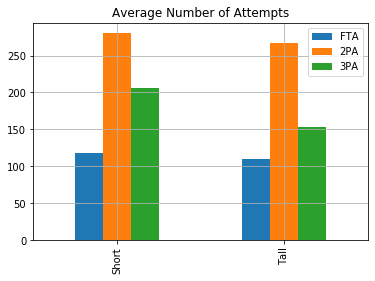

In [34]:
tall_short_avg[['FTA','2PA','3PA']].plot(kind='bar', grid=True)
plt.title('Average Number of Attempts')
plt.xlabel(None)
plt.show()

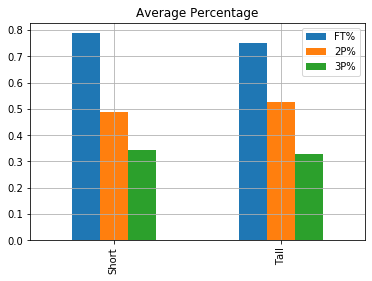

In [35]:
tall_short_avg[['FT%','2P%','3P%']].plot(kind='bar', grid=True)
plt.title('Average Percentage')
plt.xlabel(None)
plt.show()

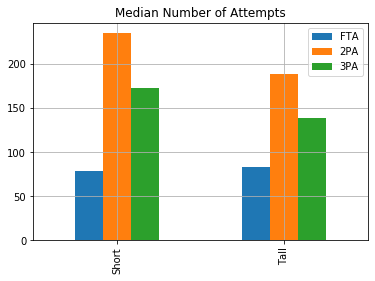

In [36]:
tall_short_med[['FTA','2PA','3PA']].plot(kind='bar', grid=True)
plt.title('Median Number of Attempts')
plt.xlabel(None)
plt.show()

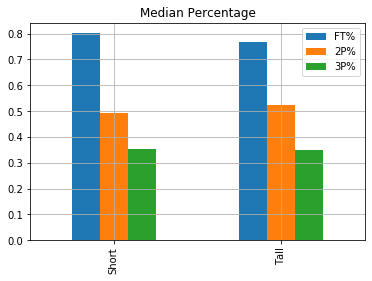

In [37]:
tall_short_med[['FT%','2P%','3P%']].plot(kind='bar', grid=True)
plt.title('Median Percentage')
plt.xlabel(None)
plt.show()

In [38]:
tall_short_gb[['FTA','2PA','3PA']].mean()

,FTA,2PA,3PA
Tall_Short,,,
Short,118.478632,280.341880,206.111111
Tall,109.372549,266.794118,152.676471


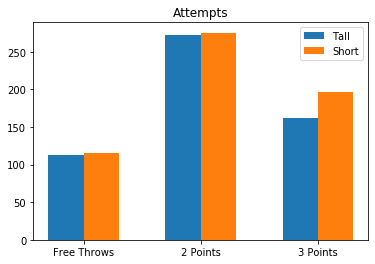

In [39]:
N = 3
tall_players_stats = (112.393939, 272.444444, 162.313131)
short_players_stats = (115.758333, 275.341667, 196.825000)

ind = np.arange(N) 
width = 0.30

plt.bar(ind, tall_players_stats, width, label='Tall')
plt.bar(ind + width, short_players_stats, width, label='Short')

plt.title('Attempts')

plt.xticks(ind + width / 2, ('Free Throws', '2 Points', '3 Points'))
plt.legend(loc='best')
plt.show()

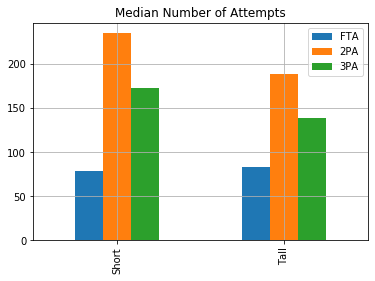

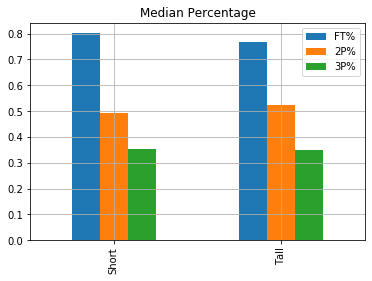

,FTA,2PA,3PA,FT%,2P%,3P%
Short,79.0,235.0,173.0,0.802,0.492,0.354
Tall,83.0,188.5,138.5,0.766,0.523,0.348


In [40]:
### Big Man Positions vs Average (Median)

tall_short_med=tall_short_gb[['FTA','2PA','3PA','FT%','2P%','3P%']].median()
tall_short_med.rename_axis(None,inplace=True)

tall_short_med[['FTA','2PA','3PA']].plot(kind='bar', grid=True)
plt.title('Median Number of Attempts')
plt.xlabel(None)
plt.show()

tall_short_med[['FT%','2P%','3P%']].plot(kind='bar', grid=True)
plt.title('Median Percentage')
plt.xlabel(None)
plt.show()

tall_short_med